# Gymnasium Basics

This notebook walks through the basics of the gymnasium package and interface. We start by exploring some simple gyms and policies to solve them, then we take a closer look at our environment of interest, MuJoCo.

## Table of Contents
1. [Basic Gym Environments](#Basic-Gym-Environments)
    - [Simple Environments, Random Policies](#Simple-Environments,-Random-Policies)
    - [Solving LunarLander with StableBaselines](#Solving-LunarLander-with-StableBaselines)
3. [The MuJoCo Environment](#The-MuJoCo-Environment)
    - [Simple Tasks, Random Policies](#Simple-Tasks,-Random-Policies)
    - [Making Humans Walk with StableBaselines](#Making-Humans-Walk-with-StableBaselines)

## Basic Gym Environments

Though we're using a more complicated gymnasium environment, it's useful to get familiar with the library and its interface through simple examples. We'll explore 3-4 of these examples in this section.

### Simple Environments, Random Policies

To begin, let's see how agents perform in these environments whenever they're chosing random actions.

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import os

In [2]:
def play_agent(env_name, model=None, n_timesteps=500):
    """Plays 500 games according to a policy. Random policy is default."""
    env = gym.make(env_name, render_mode="human")
    obs, info = env.reset()
    rewards = []

    for _ in range(n_timesteps):  # Run for 500 timesteps or until the episode ends
        env.render()
        if model: #action selection -- either according to passed in policy or random policy
            action, _ = model.predict(obs)
        else:
            action = env.action_space.sample()
        observation, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        if terminated or truncated:
            observation, info = env.reset()
    env.close()
    return rewards

In [3]:
environments = ["CartPole-v1", "MountainCar-v0", "Acrobot-v1", "LunarLander-v3"]
for env_name in environments:
    print(f"Running {env_name}...")
    play_agent(env_name, None)

Running CartPole-v1...
Running MountainCar-v0...
Running Acrobot-v1...
Running LunarLander-v3...


Performance is pretty poor! But this gives us a sense of the environment and what to expect out of optimal policies.

### Solving LunarLander with StableBaselines

Let's focus in on the [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) environment. The goal of this environment is to land a craft between two flags. You get positive reward for episodes where you land between the flags, negative reward else. We will first see an agent which uses random actions play, then an agent which we've trained, then finally we can compare their rewards over 1000 timesteps. Note it typically takes about 1M timesteps to train a decent LunarLander which may take a few minutes! Go grab a cup of coffee.

In [4]:
from stable_baselines3 import PPO

def train_agent(env_name, timesteps=10000, save_path=""):
    """Train a simple PPO policy with an MLP, available simply via StableBaselines3!"""
    env = gym.make(env_name)
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=timesteps)
    if save_path != "":
        model.save(save_path)
    env.close()
    return model

In [5]:
timesteps = 1000000
if f'lunar_lander_{timesteps}.zip' not in os.listdir("../models/"):  #training our model -- note: 1M is needed for 'good' performance, but that takes a while
    print(f"no model found, training new model for {timesteps} timesteps")
    lunar_lander_model = train_agent('LunarLander-v3', timesteps) #train lunar lander model
    lunar_lander_model.save(f"../models/lunar_lander_{timesteps}")
else:
    print(f"model found, loading cached model!")
    lunar_lander_model = PPO.load(f"../models/lunar_lander_{timesteps}.zip") #load lunar lander model if cached

model found, loading cached model!


In [6]:
timesteps = 1000
random_rewards = play_agent("LunarLander-v3", None, timesteps) #test + show random policy

In [7]:
trained_rewards = play_agent("LunarLander-v3", lunar_lander_model, timesteps) #test + show trained policy

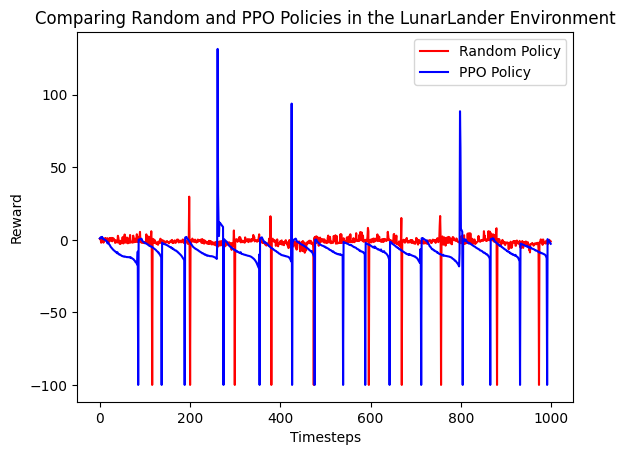

In [8]:
#compare random and trained policy results visually!
plt.plot(range(timesteps), random_rewards, color='red', label='Random Policy')
plt.plot(range(timesteps), trained_rewards, color='blue', label='PPO Policy')
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Comparing Random and PPO Policies in the LunarLander Environment")
plt.legend()
plt.show()

## The MuJoCo Environment

### Simple Tasks, Random Policies

To get situated within the MuJoCo environment let's explore the [InvertedPendulum](https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/) and [Reacher](https://gymnasium.farama.org/environments/mujoco/reacher/) environments! These are great environments to start with because they're simple and also fairly direct analogs for simpler gym environments, [Cartpole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) and [Acrobot](https://gymnasium.farama.org/environments/classic_control/acrobot/).

In [9]:
_ = play_agent('InvertedPendulum-v5', None)

In [10]:
_ = play_agent('Reacher-v5', None)

### Making Humans Walk with StableBaselines

As mentioned above, the InvertedPendulum and Reacher are really just versions of trivial classic control problems. But we're going to be using world models, so let's do something a little harder! Let's make a human walk with the [Humanoid]() environment!

This environment is much more complex than the simple MuJoCo environments. It has 16 actions and 44 observations, far more than any environment we've seen. It also has a more complex reward sturcture, rewarding forward movement but also regularizing against large motions. More than just the environment structure, the simulation itself is also more complex and takes much longer to render than simple environments -- again, this makes for a great candidate for world models, where we might be able to train efficiently in dreams!

Let's start by observing a random policy. Then we'll train a policy with StableBaselines and compare.

In [11]:
timesteps = 1000
random_rewards = play_agent('Humanoid-v5', None, timesteps)

In [12]:
if f'humanoid_{timesteps}.zip' not in os.listdir("../models/"):
    print(f"no model found, training new model for {timesteps} timesteps")
    humanoid_model = train_agent('Humanoid-v5', timesteps) #train humanoid model
    humanoid_model.save(f"../models/humanoid_{timesteps}")
else:
    print(f"model found, loading cached model!")
    humanoid_model = PPO.load(f"../models/humanoid_{timesteps}.zip")
trained_rewards = play_agent('Humanoid-v5', humanoid_model, timesteps) #test humanoid model

model found, loading cached model!


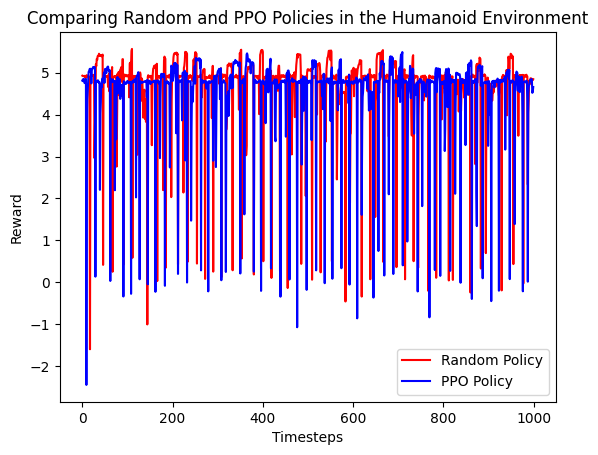

In [13]:
#compare random and trained policy results visually!
plt.plot(range(timesteps), random_rewards, color='red', label='Random Policy')
plt.plot(range(timesteps), trained_rewards, color='blue', label='PPO Policy')
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Comparing Random and PPO Policies in the Humanoid Environment")
plt.legend()
plt.show()